# Correlation for CO2, GDP, Energy

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

### Config

In [2]:
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']

G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

FEATURES = [
    'fossil_fuel_consumption', 'energy_per_capita',
    'electricity_generation', 'population',
    'nuclear_consumption', 'renewables_consumption'
]

DEVELOPED_COUNTRIES = [
    'United States', 'Japan', 'Germany', 'United Kingdom',
    'France', 'Italy', 'Canada', 'Australia', 'South Korea'
]

DEVELOPING_COUNTRIES = [
    'China', 'Brazil', 'Russia', 'India', 'Mexico', 'Indonesia',
    'Turkey', 'Saudi Arabia', 'South Africa', 'Argentina'
]

### Data Load

In [3]:
def load_data(save_dir='data_export'):
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')
    lag_df = pd.read_pickle(lag_path)
    print(f"Data Shape: {lag_df.shape}")
    return lag_df

### Corr funcs

In [4]:
def calculate_country_correlation(data, target, countries=None):
    if countries is None:
        countries = G20_COUNTRIES

    country_target_data = {}
    
    for country in countries:
        country_data = data[data['country'] == country].copy()
        if target in country_data.columns:
            country_series = country_data[['year', target]].dropna()
            country_series = country_series.set_index('year')[target]
            country_target_data[country] = country_series

    df = pd.DataFrame(country_target_data)

    corr_matrix = df.corr()

    return corr_matrix

In [5]:
def calculate_all_correlation(data, target, features, countries=None):
    if countries is None:
        countries = G20_COUNTRIES

    corr_df = calculate_country_correlation(data, target, countries)
    
    return corr_df

In [6]:
def create_correlation_heatmap(corr_df, target, save_dir='data_export/05_01_country_correlation'):
    os.makedirs(save_dir, exist_ok=True)

    fig, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax)
    
    ax.set_title(f'Correlations with {target.upper()} by Country', 
                 fontsize=14, pad=20)
    ax.set_xlabel('Countries', fontsize=12)
    ax.set_ylabel('Countries', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    plot_path = os.path.join(save_dir, f'{target}_correlation_heatmap.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    
    return fig

In [7]:
def rank_country_sim(corr_df, save_dir='data_export/05_01_country_correlation'):
    os.makedirs(save_dir, exist_ok=True)
    
    ranking_results = []

    for country in corr_df.index:
        country_corr = corr_df.loc[country].drop(country)
        sorted_corr = country_corr.abs().sort_values(ascending=False)
        
        for rank, similar_country in enumerate(sorted_corr.index, 1):
            actual_corr = corr_df.loc[country, similar_country]
            abs_corr = abs(actual_corr)
            
            ranking_results.append({
                'country': country,
                'rank': rank,
                'similar_country': similar_country,
                'correlation': actual_corr,
                'abs_correlation': abs_corr
            })
    
    ranking_df = pd.DataFrame(ranking_results)
    
    return ranking_df

In [8]:
def categorise_correlation(ranking_df):
    top_sim = ranking_df[ranking_df['rank'] == 1].copy()

    categories = {}
    processed = set()
    
    for _, row in top_sim.iterrows():
        country = row['country']
        similar = row['similar_country']
        
        if country not in processed:
            group_key = f"{country} - {similar}"
            if group_key not in categories:
                categories[group_key] = []
            
            categories[group_key].append({
                'country': country,
                'most_similar': similar,
                'similarity': row['similarity']
            })
            processed.add(country)
    
    return categories

In [9]:
def create_ranking_summary(ranking_df, target, save_dir='data_export/05_01_country_correlation'):
    os.makedirs(save_dir, exist_ok=True)

    top3_df = ranking_df[ranking_df['rank'] <= 3].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Country Similarity Rankings for {target.upper()}', fontsize=16)
    
    ax1 = axes[0]
    top_similar_counts = ranking_df[ranking_df['rank'] == 1]['similar_country'].value_counts().head(10)
    top_similar_counts.plot(kind='barh', ax=ax1, color='blue', alpha=0.8)
    ax1.set_title('Most Frequently #1 Similar Country', fontsize=12)
    ax1.set_xlabel('Number of Countries', fontsize=11)
    ax1.set_ylabel('Country', fontsize=11)
    ax1.invert_yaxis()

    for i, v in enumerate(top_similar_counts.values):
        ax1.text(v + 0.1, i, str(v), va='center', fontsize=10)

    ax2 = axes[1]
    avg_similarity = ranking_df.groupby('rank')['similarity'].mean()
    avg_similarity.plot(kind='line', ax=ax2, marker='o', color='yellow', linewidth=2, markersize=8)
    ax2.set_title('Average Similarity Score by Rank', fontsize=12)
    ax2.set_xlabel('Rank', fontsize=11)
    ax2.set_ylabel('Average Similarity', fontsize=11)
    ax2.set_ylim(-1, 1)

    for x, y in zip(avg_similarity.index, avg_similarity.values):
        if x <= 10:
            ax2.text(x, y + 0.05, f'{y:.2f}', ha='center', fontsize=9)
    
    plt.tight_layout()

    plot_path = os.path.join(save_dir, f'{target}_ranking_summary.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    
    return fig

In [10]:
def run_correlation_analysis(target, countries=None, save_dir='data_export/05_01_country_correlation'):
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Correlation for {target.upper()}\n")
    
    data = load_data()
    
    if countries is None:
        countries = G20_COUNTRIES
    
    corr_df = calculate_all_correlation(data, target, FEATURES, countries)
    
    if corr_df.empty:
        print(f"No correlation data available for {target}")
        return None
    
    print(f"Correlation matrix shape: {corr_df.shape}")
    
    corr_path = os.path.join(save_dir, f'{target}_correlations.csv')
    corr_df.to_csv(corr_path)
    
    # Create heatmap
    fig_heatmap = create_correlation_heatmap(corr_df, target, save_dir)
    plt.show()
    
    results = {
        'correlations': corr_df
    }
    
    return results

In [11]:
def run_all_targets_analysis(save_dir='data_export/05_01_country_correlation'):
    os.makedirs(save_dir, exist_ok=True)
    
    all_results = {}
    
    for target in TARGET_VARIABLES:
        results = run_correlation_analysis(target, save_dir=save_dir)
        if results is not None:
            all_results[target] = results
    
    return all_results

Correlation for CO2

Data Shape: (1138, 992)
Correlation matrix shape: (19, 19)


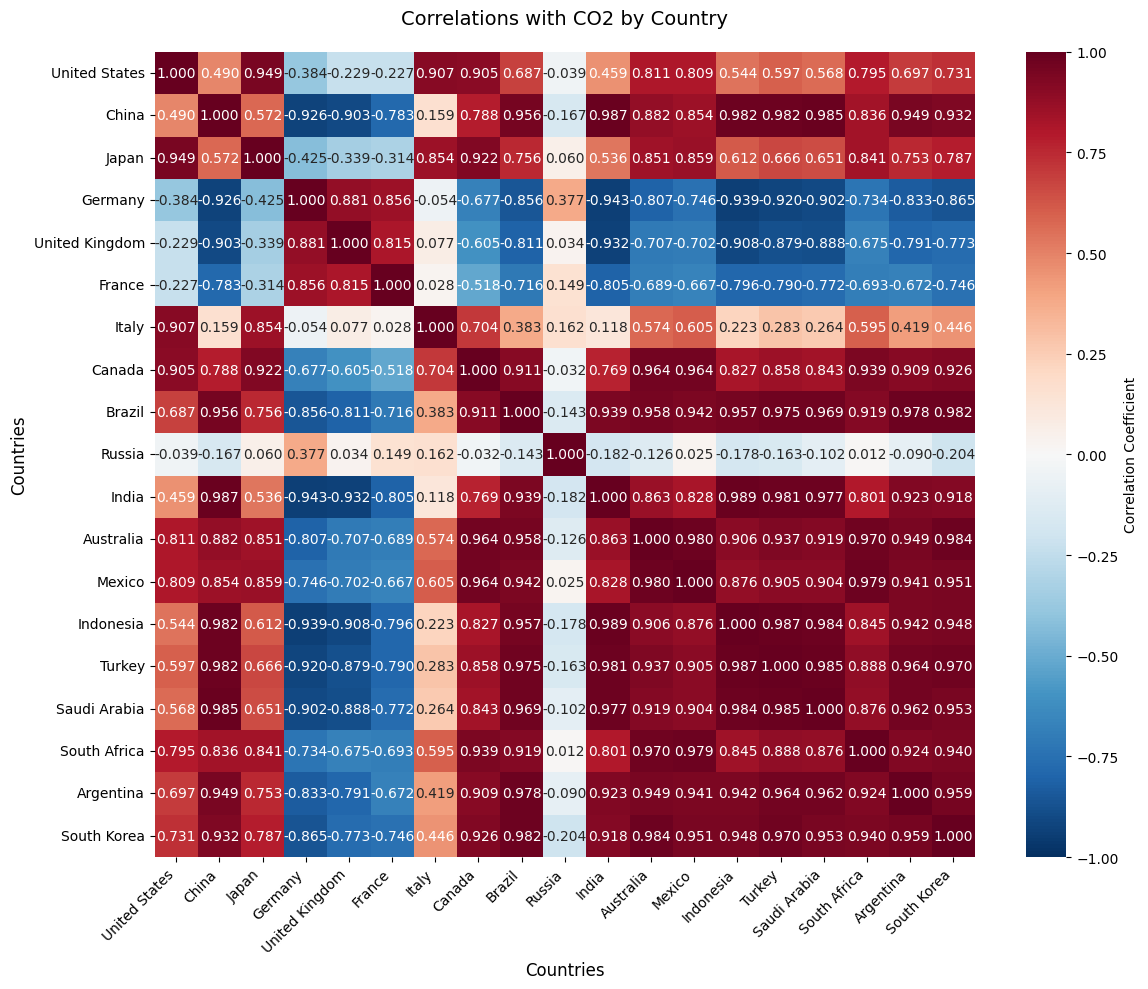

In [12]:
co2_results = run_correlation_analysis('co2')

Correlation for GDP

Data Shape: (1138, 992)
Correlation matrix shape: (19, 19)


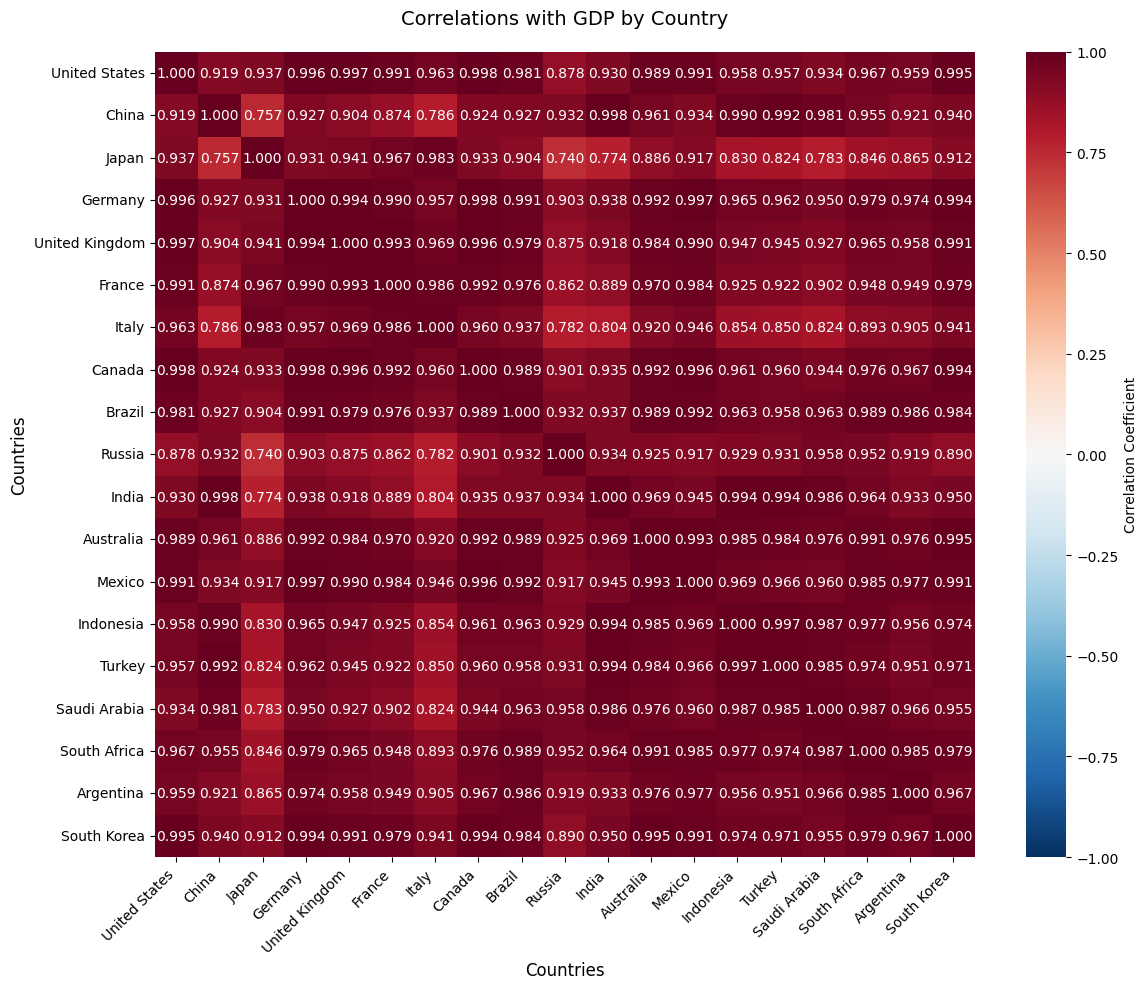

In [13]:
gdp_results = run_correlation_analysis('gdp')

Correlation for PRIMARY_ENERGY_CONSUMPTION

Data Shape: (1138, 992)
Correlation matrix shape: (19, 19)


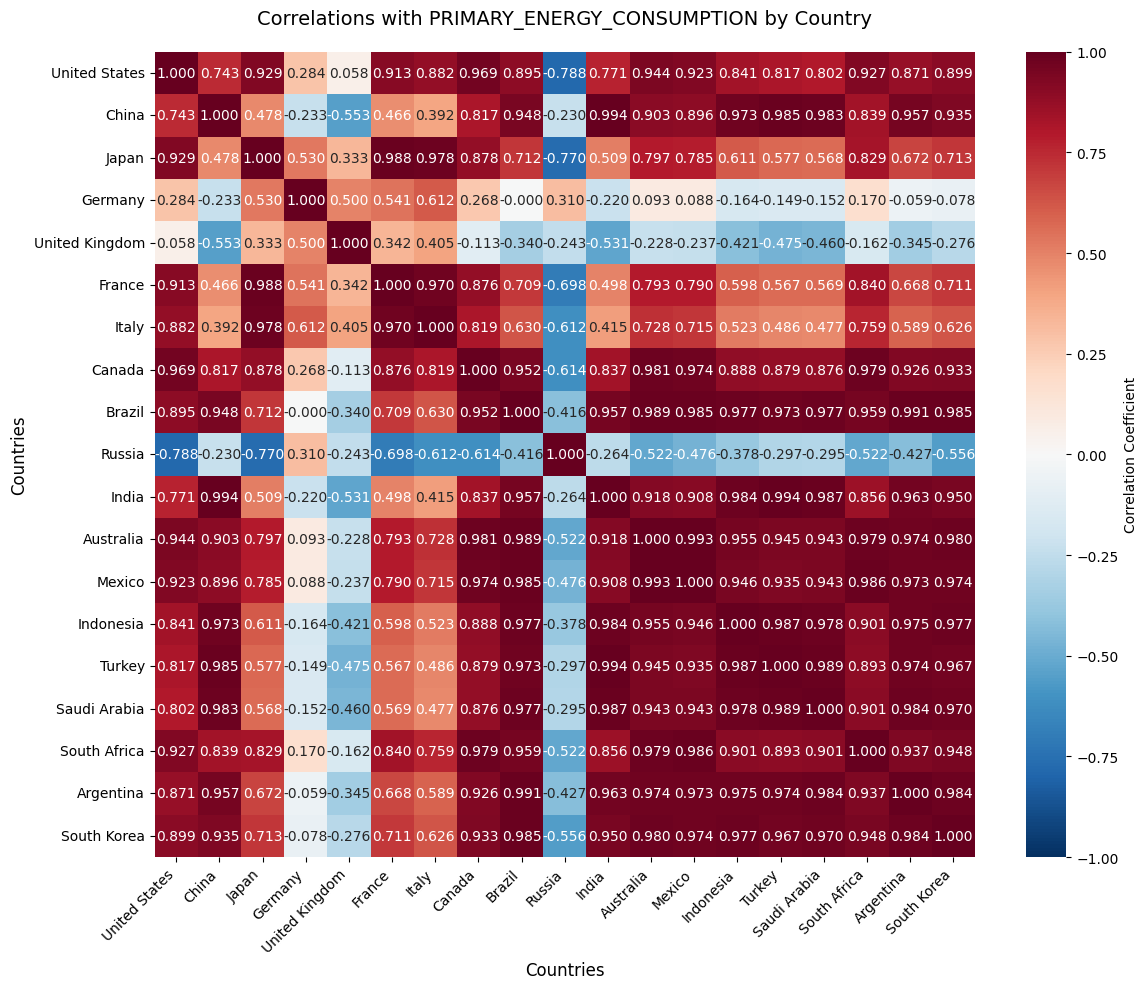

In [14]:
energy_results = run_correlation_analysis('primary_energy_consumption')

Correlation for CO2

Data Shape: (1138, 992)
Correlation matrix shape: (19, 19)


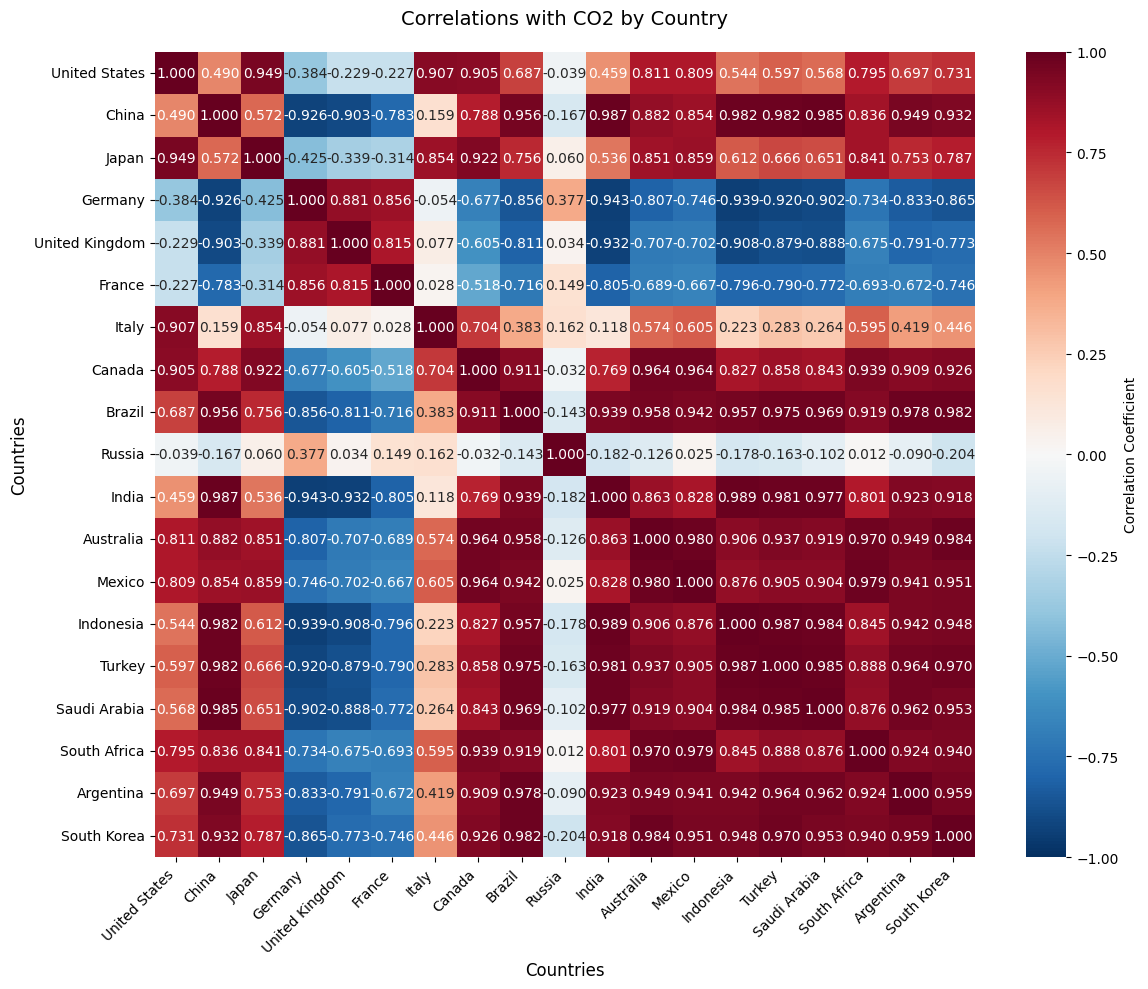

Correlation for GDP

Data Shape: (1138, 992)
Correlation matrix shape: (19, 19)


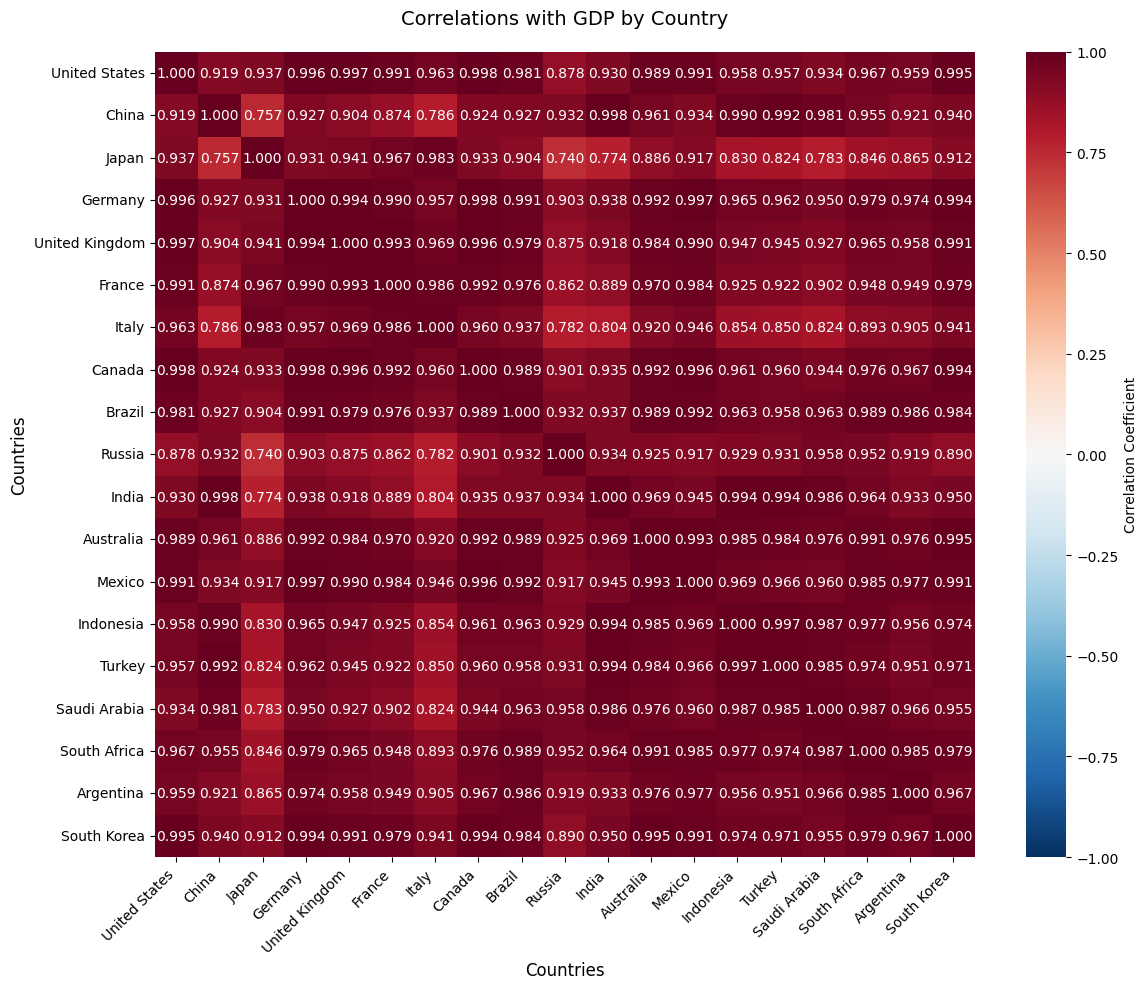

Correlation for PRIMARY_ENERGY_CONSUMPTION

Data Shape: (1138, 992)
Correlation matrix shape: (19, 19)


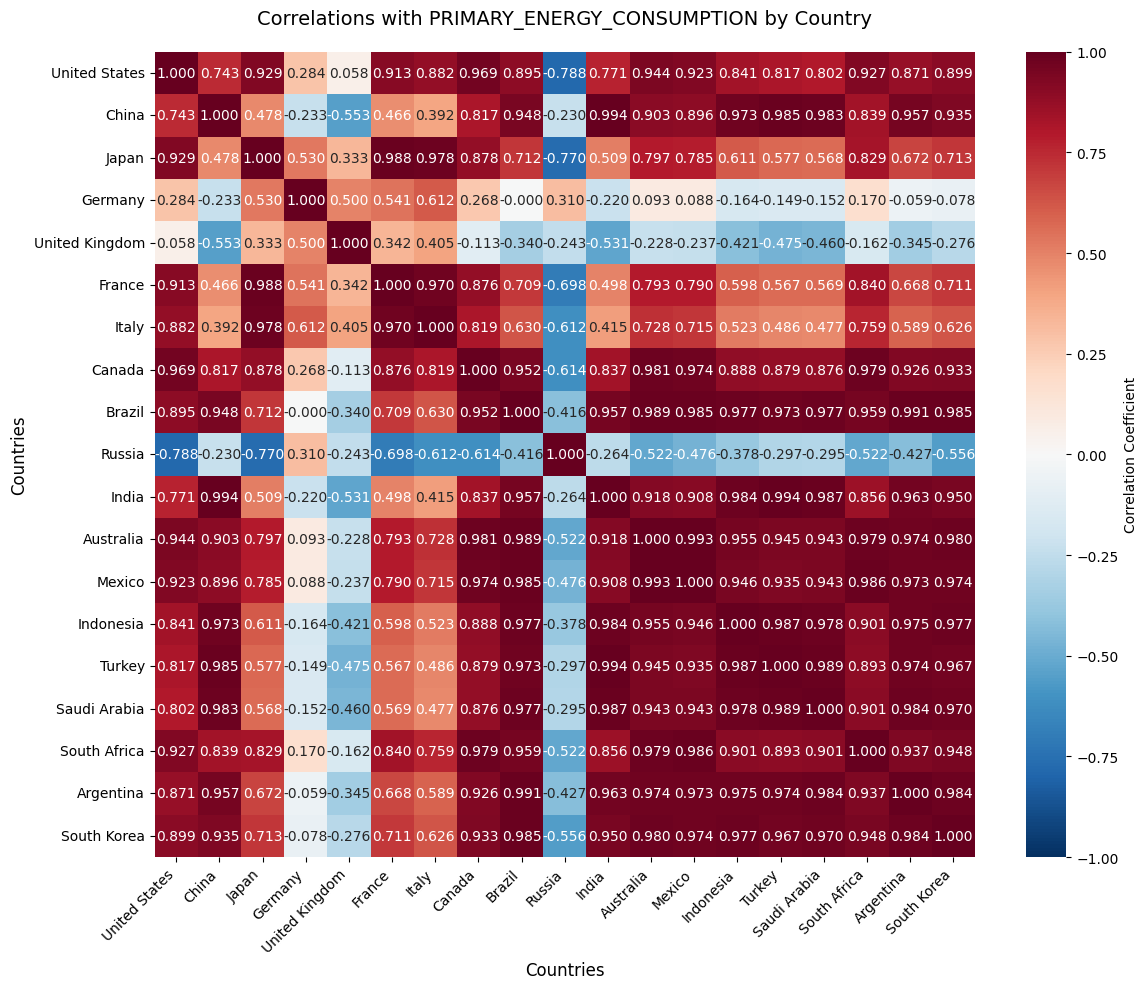

In [15]:
all_results = run_all_targets_analysis()